In [1]:
import pandas as pd
import numpy as np

In [9]:
# Load DataSet

df = pd.read_csv("../data/globalAirQuality.csv")

In [18]:
# preview dataset
print("info")
print(df.info())

print("first five rows")
print(df.head())

print("rows x columns")
print(df.shape)

print("columns present in the dataset")
print(df.columns)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    18000 non-null  object 
 1   country      18000 non-null  object 
 2   city         18000 non-null  object 
 3   latitude     18000 non-null  float64
 4   longitude    18000 non-null  float64
 5   pm25         18000 non-null  float64
 6   pm10         18000 non-null  float64
 7   no2          18000 non-null  float64
 8   so2          18000 non-null  float64
 9   o3           18000 non-null  float64
 10  co           18000 non-null  float64
 11  aqi          18000 non-null  int64  
 12  temperature  18000 non-null  float64
 13  humidity     18000 non-null  float64
 14  wind_speed   18000 non-null  float64
dtypes: float64(11), int64(1), object(3)
memory usage: 2.1+ MB
None
first five rows
                    timestamp country      city  latitude  longitude    pm25  \
0  2025-

In [27]:
# Reduced DataFrame

df_main = df[["timestamp","country","city","pm25","aqi"]].copy()

# verify
print("Reduced Dataset")
print(df_main.head())
print("Shape of the reduced dataset")
print(df_main.shape)
print("Columns")
print(df_main.columns)

Reduced Dataset
                    timestamp country      city    pm25  aqi
0  2025-11-04 18:25:17.554219      US  New York  50.295  108
1  2025-11-04 19:25:17.554219      US  New York  32.083   90
2  2025-11-04 20:25:17.554219      US  New York  42.250   84
3  2025-11-04 21:25:17.554219      US  New York  30.403  158
4  2025-11-04 22:25:17.554219      US  New York  21.083   97
Shape of the reduced dataset
(18000, 5)
Columns
Index(['timestamp', 'country', 'city', 'pm25', 'aqi'], dtype='object')


In [34]:
# Data cleaning

# timestamp dtype change object -> datatime64[ns]
print(df_main["timestamp"].dtype) # object

# operation
df_main["timestamp"] = pd.to_datetime(df_main["timestamp"])

# After cleaning
print(df_main["timestamp"].dtype)

# duplicate handling
print(df_main.duplicated().sum()) # already cleaned

# checking NaN values
print(df_main.isnull().sum()) # already cleaned

# standardize text colums
df_main["country"] = df_main["country"].str.upper()
df_main["city"] = df_main["city"].str.title()

df_main

datetime64[ns]
datetime64[ns]
0
timestamp    0
country      0
city         0
pm25         0
aqi          0
dtype: int64


,timestamp,country,city,pm25,aqi
0,2025-11-04 18:25:17.554219,US,New York,50.295,108
1,2025-11-04 19:25:17.554219,US,New York,32.083,90
2,2025-11-04 20:25:17.554219,US,New York,42.250,84
3,2025-11-04 21:25:17.554219,US,New York,30.403,158
4,2025-11-04 22:25:17.554219,US,New York,21.083,97
...,...,...,...,...,...
17995,2025-11-19 13:25:17.554219,CH,Zurich,27.899,103
17996,2025-11-19 14:25:17.554219,CH,Zurich,2.950,105
17997,2025-11-19 15:25:17.554219,CH,Zurich,61.347,122
17998,2025-11-19 16:25:17.554219,CH,Zurich,40.722,95


In [52]:
# Feature Engineering

df_main["air_quality_category" ] = df_main["aqi"].apply(
    lambda x : (
        "Good" if x <=50 else
        "Moderate" if x <= 100 else
        "Poor" if x <= 150 else
        "Very Poor"
    )
)
threshold = 35
df_main["pm25_level"] = df_main["pm25"].apply(
    lambda x : (
        "Low" if x <= 12 else
        "Medium" if x <= 35 else
        "High"
    )
)

df_main["high_pollution"] = df_main["pm25"].apply(
    lambda x : (
        True if x > threshold else False
    )
)



print(df_main.head())

# sanity check
print(df_main["air_quality_category"].value_counts())
print(df_main["pm25_level"].value_counts())
print(df_main["high_pollution"].value_counts())

                   timestamp country      city    pm25  aqi  \
0 2025-11-04 18:25:17.554219      US  New York  50.295  108   
1 2025-11-04 19:25:17.554219      US  New York  32.083   90   
2 2025-11-04 20:25:17.554219      US  New York  42.250   84   
3 2025-11-04 21:25:17.554219      US  New York  30.403  158   
4 2025-11-04 22:25:17.554219      US  New York  21.083   97   

  air_quality_category  high_pollution pm25_level  
0                 Poor            True       High  
1             Moderate           False     Medium  
2             Moderate            True       High  
3            Very Poor           False     Medium  
4             Moderate           False     Medium  
air_quality_category
Poor         8874
Moderate     8108
Very Poor     847
Good          171
Name: count, dtype: int64
pm25_level
High      11048
Medium     5950
Low        1002
Name: count, dtype: int64
high_pollution
True     11048
False     6952
Name: count, dtype: int64


In [62]:
# Data Analysis

# which country have higher air pollution on average?

country_summary = (df_main.groupby("country").agg(
    avg_pm25 = ("pm25","mean"),
    avg_aqi = ("aqi","mean"),
    high_pollution_count = ("high_pollution","sum")
)
    .reset_index()
)

# Rank countries by pm25
country_summary = country_summary.sort_values(
        by = "avg_pm25",
        ascending = False
)

country_summary["pollution_rank"] = country_summary["avg_pm25"].rank(
    method = "dense",
    ascending = False
)

print(country_summary)

   country   avg_pm25     avg_aqi  high_pollution_count  pollution_rank
26      PK  41.774103  106.300000                   217             1.0
16      IR  41.627239  102.150000                   238             2.0
33      TH  41.426669  105.191667                   228             3.0
28      QA  41.288150  107.366667                   228             4.0
22      MY  41.146956  105.005556                   238             5.0
17      IT  41.146922  105.033333                   227             6.0
29      RU  41.100336  106.197222                   227             7.0
30      SA  41.014103  104.772222                   228             8.0
7       DE  41.007858  104.422222                   222             9.0
11      FR  40.931239  105.763889                   232            10.0
19      KE  40.911714  104.747222                   229            11.0
23      NG  40.887861  106.616667                   222            12.0
2       AU  40.807443  103.461111                   456         

In [76]:
# city wise analysis

city_summary = (
    df_main.groupby("city").agg(
        avg_pm25 = ("pm25","mean"),
        avg_aqi = ("aqi","mean"),
        high_pollution_count = ("high_pollution","sum")
    )
    .reset_index()
)

city_summary = city_summary.sort_values(
    by = "avg_pm25",
    ascending = False
)

city_summary["pollution_rank"] = city_summary["avg_pm25"].rank(
    method = "dense",
    ascending = False
)
print(city_summary.head())


top_10_cities = city_summary.head(10)

print(top_10_cities)

       city   avg_pm25     avg_aqi  high_pollution_count  pollution_rank
19  Karachi  41.774103  106.300000                   217             1.0
44   Tehran  41.627239  102.150000                   238             2.0
42   Sydney  41.617336  104.477778                   232             3.0
8   Chennai  41.613775  103.627778                   233             4.0
1   Bangkok  41.426669  105.191667                   228             5.0
            city   avg_pm25     avg_aqi  high_pollution_count  pollution_rank
19       Karachi  41.774103  106.300000                   217             1.0
44        Tehran  41.627239  102.150000                   238             2.0
42        Sydney  41.617336  104.477778                   232             3.0
8        Chennai  41.613775  103.627778                   233             4.0
1        Bangkok  41.426669  105.191667                   228             5.0
11          Doha  41.288150  107.366667                   228             6.0
21  Kuala Lumpur

array([[<Axes: title={'center': 'avg_pm25'}>,
        <Axes: title={'center': 'avg_aqi'}>],
       [<Axes: title={'center': 'high_pollution_count'}>,
        <Axes: title={'center': 'pollution_rank'}>]], dtype=object)

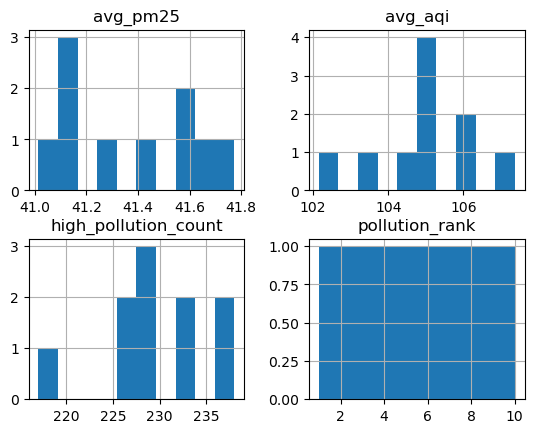

In [80]:
# Data visualization
top_10_cities.hist()

In [82]:
# output
country_summary.to_csv("../output/country_pollution_summary.csv", index = False)

city_summary.to_csv("../output/city_pollution_summary.csv",index=False)

top_10_cities.to_csv("../output/top_10_cities.csv",index = False)
